## Implementation of skip - gram model

Goal: to build a word embedding dictionary from the mutual fund prospectus in the training set

#### Load the data --> RAG results

In [1]:
import numpy as np
import pandas as pd
import sys
from sklearn.model_selection import train_test_split


import os
path = os.getcwd()

In [2]:
path

'/Users/Christian/Desktop/MSMFT/Semester 2/Machine Learning/MF815-Mutual-Fund-Style-Classification'

In [3]:
csv_path = path + "/NLP_app/MutualFundLabelsPlusPredictions.csv"

In [4]:
df = pd.read_csv(csv_path)

df = df.dropna(subset=["Prediction"]).copy()
print(df.head())


                     id                         fund_name Performance fee?  \
0  0000051931-18-000151  American Funds College 2018 Fund              NaN   
1  0000051931-18-000151  American Funds College 2021 Fund              NaN   
2  0000051931-18-000151  American Funds College 2024 Fund              NaN   
3  0000051931-18-000151  American Funds College 2027 Fund              NaN   
4  0000051931-18-000151  American Funds College 2030 Fund              NaN   

        Investment Strategy Derivatives_label        Portfolio composition  \
0  Balanced Fund (Low Risk)               Yes  Investment grade securities   
1  Balanced Fund (Low Risk)               Yes  Investment grade securities   
2  Balanced Fund (Low Risk)               Yes  Investment grade securities   
3  Balanced Fund (Low Risk)               Yes  Investment grade securities   
4  Balanced Fund (Low Risk)               Yes  Investment grade securities   

   Concentration                        Predicted Strategy  \


#### first split the data into training, validation, and testing

In [5]:
# First split: 70% training, 30% temporary
df_training, df_testing = train_test_split(
    df,
    test_size=0.30,
    stratify=df["Prediction"],
    random_state=1
)



In [6]:
df_training.reset_index(drop=True, inplace=True)
df_testing.reset_index(drop=True, inplace=True)

In [7]:
print("Training set size:", df_training.shape)
print("Test set size:", df_testing.shape)

Training set size: (322, 10)
Test set size: (139, 10)


In [8]:
# X = features (summaries or evidence)
X_training = df_training["Strategy evidence"]
X_testing = df_testing["Strategy evidence"]
# y = labels (predicted strategy from RAG)
Y_training= df_training["Prediction"]
Y_testing = df_testing['Prediction']


In [9]:
X_training

0      Vanguard Russell 1000 Index Fund <head_breaker...
1      Principal Investment Strategies\n\nNormally in...
2      Fidelity Advisor Semiconductors Fund\n\n<head_...
3      The dynamic asset allocation strategy seeks to...
4      Variable Portfolio\n\nBlackRock Global Inflati...
                             ...                        
317    Principal investment strategies The fund will ...
318    The Subadvisor takes a "bottom-up" investment ...
319    Principal Investment Strategies\n\nMFS (Massac...
320    The fund invests the remainder of its assets i...
321                      Principal Investment Strategies
Name: Strategy evidence, Length: 322, dtype: object

### Skip Gram Model Implementation

In [10]:
# Install tensorflow 2 to the virtual environment.
!pip install "tensorflow>=2.15.0"
!pip install --upgrade tensorflow-hub

# Restart Runtime after installation !
# -> Runtime -> Restart Runtime...
# Rerun the cell when the runtime has restarted

In [11]:
# Import the libraries
import os
import sys
from IPython.display import HTML, display

import numpy as np
import pandas as pd
import tensorflow as tf
from math import ceil
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import random
import time
import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Christian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Christian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/Christian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Util
Some useful functions. <br>
You don’t really need to understand them, these are utilities functions.


In [12]:
# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Save a word2vec dictionary.
def save_word2vec(filename):
    #with open(os.path.join('/Users/haoxing/Documents/Work/Teaching/Machine learning for Finance/Codes/NLP/NLP_app', filename),'a' , encoding='utf-8') as f :
    with open(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/', filename),'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    #with open(os.path.join('/Users/haoxing/Documents/Work/Teaching/Machine learning for Finance/Codes/NLP/NLP_app', filename), encoding='utf8') as f:
    with open(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/', filename), encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        texts.append(summary)
        fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

### Preprocess the texts
#### Normalize text to reduce inflectional forms

In [13]:
df['Strategy evidence'][1]

'American Funds College 2021 Fund <head_breaker>\n\nAmerican Funds College 2021 Fund\n\nInvestment objectives The fund will seek to achieve the following objectives to varying degrees: growth, income and preservation of capital, depending on the proximity to its target date. The target date is meant to roughly correspond to the year in which the fund beneficiary will start to withdraw funds to meet higher education expenses. The fund will increasingly emphasize income and preservation of capital by investing a greater portion of its assets in bond, equity-income and balanced funds as it approaches and passes its target date. In this way, the fund seeks to achieve an appropriate balance of total return and stability during different time periods.'

In [14]:
stop_words = set(list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])

In [15]:
# tokenizer removes the stop words the tokens with no letters, tokens with non letter characters, and tokens with less than 3 letters
def tokenizer(txt):
    txt = txt.replace('\n', ' ').replace('\t', ' ').replace("'", " ").replace("<head breaker>", " ").replace("\n\n", " ")
    word_tokens = word_tokenize(txt)
    
    filtered_sentence = [
        w for w in word_tokens 
        if w not in stop_words and w.isalpha() #and len(w) >= 3
    ]

    return filtered_sentence


In [16]:
X_training[1]

'Principal Investment Strategies\n\nNormally investing at least 80% of assets in securities of issuers in emerging markets (countries that have an emerging stock market as defined by MSCI, countries or markets with low- to middle-income economies as classified by the World Bank, and other countries or markets with similar emerging characteristics) and other investments that are tied economically to emerging markets. Normally investing primarily in common stocks. Investing in either "growth" stocks or "value" stocks or both. Allocating the fund\'s assets across emerging markets sectors, using different Fidelity managers. Allocating investments across different emerging market countries. Using fundamental analysis of factors such as each issuer\'s financial condition and industry position, as well as market and economic conditions, to select investments. Principal Investment Risks'

In [17]:
text_words = np.concatenate([tokenizer(summary) for summary in X_training])

In [18]:
print(len(text_words))

32332


### Process Skip-Gram model Input

In [19]:
# Training Parameters
batch_size = 128 # The model will be trained batch per batch and one batch contains 128 rows
num_epochs = 2 # The model will go through all the data twice

* We set the dimension of our word vectors to 50. This is the embedding size and therefore the size of our hidden layer.
* We only consider the 5000 most frequent words.
* we set the window size to 3.
* Here we will only take 4 (num_skips) randomly chosen words in the local context of each word to build the input. (instead of all the local context as shown in the above example).


In [20]:
# Word2Vec Parameters
embedding_size = 50 # Dimension of the embedding vector
max_vocabulary_size = 5000 # Total number of different words in the vocabulary
min_occurrence = 10 # Remove all words that does not appears at least n times
skip_window = 3 # How many words to consider left and right
num_skips = 4 # How many times to reuse an input to generate a label

In [21]:
# Build the dictionary and replace rare words with UNK token
count = [('UNK', -1)]
# Retrieve the most common words
count.extend(collections.Counter(text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        # The collection is ordered, so stop when 'min_occurrence' is reached
        break

In [22]:
# we give a unique id to each words in our vocabulary
word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)

# SO small our vocab size

In [23]:
print ('size of the vocabulary : '+ str(vocab_size))

size of the vocabulary : 499


In [24]:
# create data
data = list()
unk_count = 0
for word in text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)

In [25]:
print(data[:20])

[0, 303, 84, 6, 0, 303, 84, 6, 19, 88, 8, 6, 41, 5, 0, 1, 97, 2, 9, 0]


In [26]:
# build OneHot vector from index
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

In [27]:
# Generate training batch for the skip-gram model
def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    data_index = 0
    while True :
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        # batch is filled with 128 inputs
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        # labels is filled with 128 outputs
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = 2 * skip_window + 1
        # buffer keep track of the visited indexes visited
        buffer = collections.deque(maxlen=span)
        if data_index + span > len(data):
            data_index = 0
            # We stop the loop when we went through all the corpus
            break
        buffer.extend(data[data_index:data_index + span])
        data_index += span
        for i in range(batch_size // num_skips):
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # Randomly select num_skips words in the context
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                # Creates one raw data
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_index == len(data):
                buffer.extend(data[0:span])
                data_index = span
            else:
                buffer.append(data[data_index])
                data_index += 1
        # Backtrack a little bit to avoid skipping words in the end of a batch
        data_index = (data_index + len(data) - span) % len(data)

        # translate word index to on-hot representation
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])

        # output one batch
        yield batch_one_hot, labels_one_hot

In [28]:
# Create en compile the Autoencoder
def creat_word2vec_model():
    input_word = Input(shape=(vocab_size,))

    encoded = Dense(embedding_size, activation='linear')(input_word)
    decoded = Dense(vocab_size, activation='softmax')(encoded)

    # The autoencoder is the whole model with hidden layer contected to the output layer.
    autoencoder = Model(input_word, decoded)
    # The encoder is just the input layer connected to the hidden layer. One the Autoencoder will be trained we will use
    # the encoder to create our word vectors
    encoder = Model(input_word, encoded)

    autoencoder.compile(optimizer='adam', loss='categorical_crossentropy') ## changed from binary
    return encoder, autoencoder

In [29]:
# We create the model
#the autoencoder is the skipgram model
encoder, autoencoder = creat_word2vec_model()

In [30]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 499)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        25,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 499)            │        25,449 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,449 (197.07 KB)

 Trainable params: 50,449 (197.07 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Finally we can train the model by feeding it with our batch generator !
autoencoder.fit(
    x=batch_generator(batch_size, num_skips, skip_window, vocab_size),
    steps_per_epoch=ceil(len(data) / batch_size),
    epochs=num_epochs
)


Epoch 1/2
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.9628
Epoch 2/2
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0806


### Encoder to vectorize

In [32]:
# Create the Vectorizer function (prediciton of the encoder)
def vecotrize(word):
    # We use the encoder to create the word vectors
    # We need to convert the word to one-hot representation
    word_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([word_one_hot]))[0]

In [33]:
# Create the word2vec dictionary
word2vec = {w : vecotrize(w) for w in word2id.keys()}

# This dictionary gives for all words it's vectorial representation.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

In [34]:
# We can save the word2vec dictionary to reuse it later.
import pickle

def save_word2vec(word2vec, filepath="word2vec.pkl"):
    with open(os.path.join(filepath), "wb") as f:
        pickle.dump(word2vec, f)

save_word2vec(word2vec, path + "NLP_app")

### Visualization

In [35]:
# for a given word, output the n closer words in the word2vec maping.
def get_n_closer(w, n, word2vec):
    vect = word2vec[w]
    distances_dict = {k: cosine(v, vect) for k, v in word2vec.items()}

    closer_words = []
    for _ in range(n):
        min_key = min(distances_dict.keys(), key=lambda k: distances_dict[k])
        closer_words.append(min_key)
        del distances_dict[min_key]
    return closer_words

In [36]:
words_neighbors_1 = get_n_closer('expenses', 10, word2vec)
print('words close to expenses : ' +str(', '.join(words_neighbors_1)))
words_neighbors_2 = get_n_closer('derivatives', 10, word2vec)
print('words close to derivatives : ' +str(', '.join(words_neighbors_2)))

words close to expenses : expenses, path, believes, conditions, no, around, Shares, fundamental, that, Using
words close to derivatives : derivatives, particular, Russell, between, maturities, value, modify, page, A, Subadvisor


In [37]:
# fit the TSNE dimenstion reduction model
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
vectors = np.array([v for k, v in word2vec.items()])
words = np.array([k for k, v in word2vec.items()])
print(vectors.shape)

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
vectors = tsne_model.fit_transform(vectors)

print(vectors.shape)

(499, 50)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


(499, 2)


In [38]:
reduced_word2vec = {words[i] : list(vectors[i]) for i in range (len(vectors))}

In [39]:
def create_neighbors_visualisation_data(words, num_neighbors, word2vec):
    words_neighbors = []
    for word in words :
        try :
            words_neighbors.append(get_n_closer(word, num_neighbors, word2vec))
        except :
            print(word +' not in word2vec')

    words_neighbors = np.concatenate(words_neighbors)
    vectors_neighbors = np.array([reduced_word2vec[word] for word in words_neighbors])

    return vectors_neighbors[:,0], vectors_neighbors[:,0], words_neighbors
x, y, labels = create_neighbors_visualisation_data(['expenses', 'derivatives'], 10, word2vec)

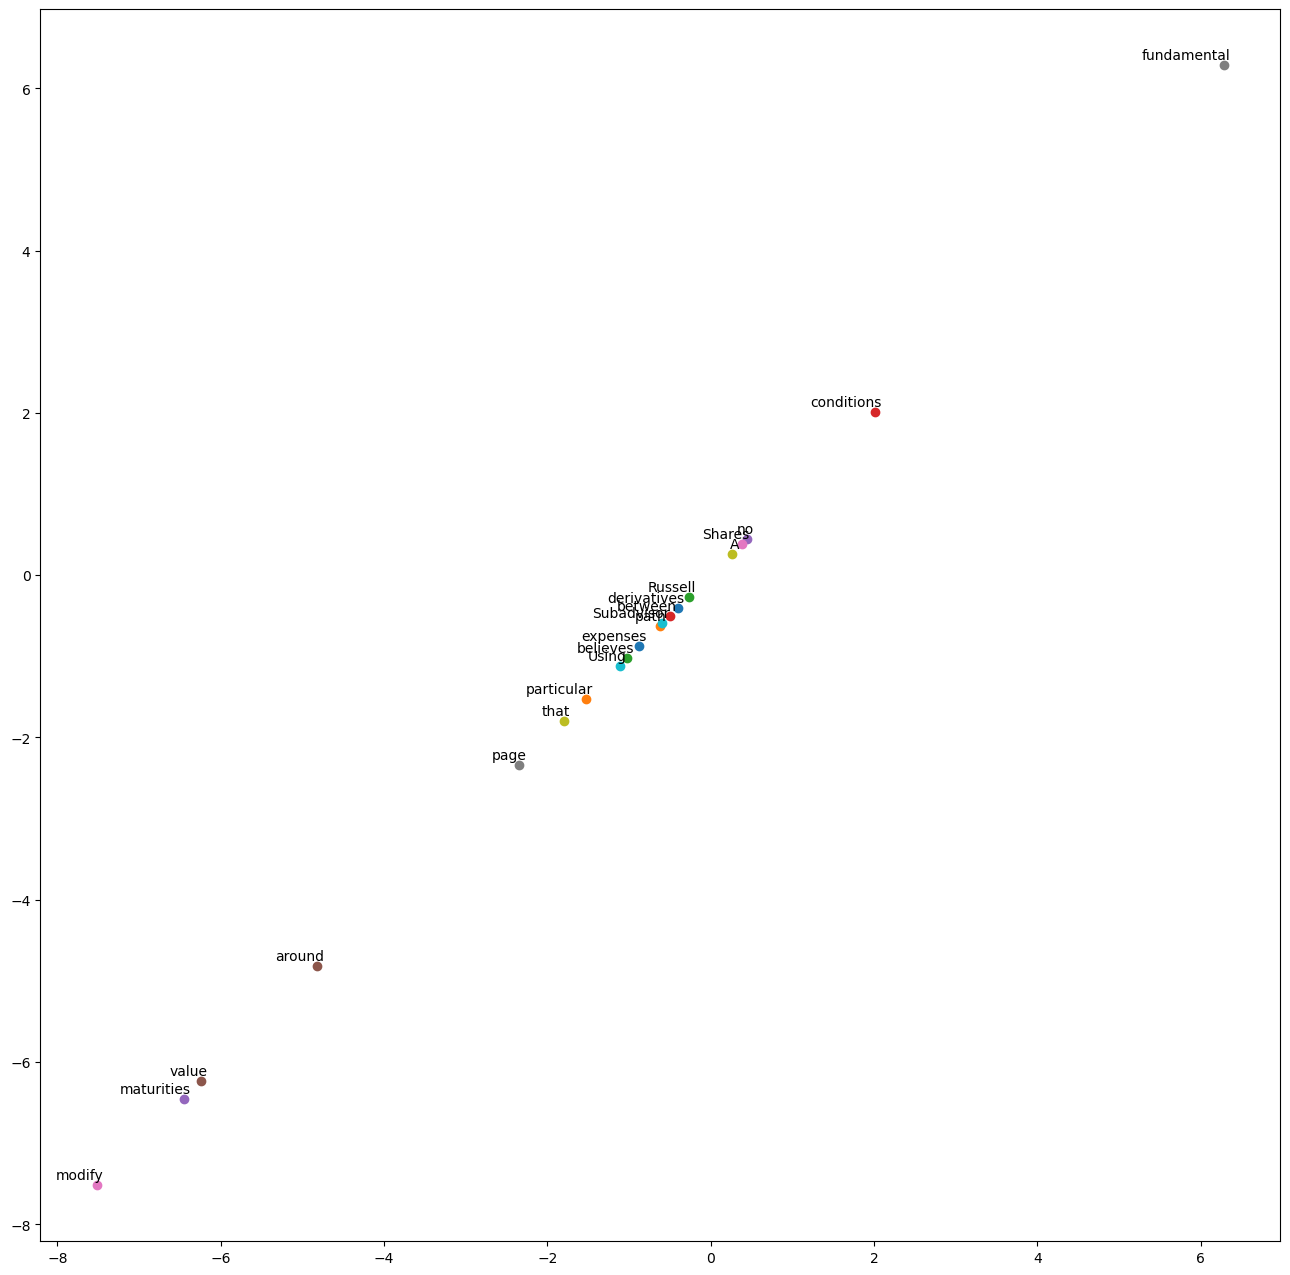

In [40]:
plt.figure(figsize=(16, 16))
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
        xy=(x[i], y[i]),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')
plt.show()

### Design a stretegy to build knowledge bases of the three main mutual funds style

In [41]:
df_balanced = df_training[df_training["Prediction"] == "Balanced Fund (Low Risk)"]
df_fixed_income = df_training[df_training["Prediction"] == "Fixed Income Long Only (Low Risk)"]
df_equity = df_training[df_training["Prediction"] == "Equity Long Only (Low Risk)"]

In [42]:
df_equity.head()

,id,fund_name,Performance fee?,Investment Strategy,Derivatives_label,Portfolio composition,Concentration,Predicted Strategy,Strategy evidence,Prediction
0,0000932471-18-008471,Vanguard Russell 1000 Index Fund,NaN,Fixed Income Long Only (Low Risk),No,Investment grade securities,Diversified,Category: Equity Long Only \nConfidence: 10,Vanguard Russell 1000 Index Fund <head_breaker...,Equity Long Only (Low Risk)
1,0001379491-18-006486,Fidelity Emerging Markets Fund,NaN,Equity Long Only (Low Risk),No,Sub-investment grade securities or emerging ma...,Diversified,Category: Equity Long Only \nConfidence: 9,Principal Investment Strategies\n\nNormally in...,Equity Long Only (Low Risk)
2,0001379491-18-003592,Fidelity Advisor Semiconductors Fund,NaN,Equity Long Only (Low Risk),No,Listed Equities,Concentrated by issuer / sector / jurisdiction,Category: Equity Long Only \nConfidence: 9,Fidelity Advisor Semiconductors Fund\n\n<head_...,Equity Long Only (Low Risk)
5,0001193125-18-139001,Variable Portfolio - Oppenheimer International...,NaN,Equity Long Only (Low Risk),No,Listed Equities,Diversified,Category: Equity Long Only \nConfidence: 9,"In addition to investing in U.S. companies, th...",Equity Long Only (Low Risk)
15,0001193125-18-227777,Ivy Mid Cap Growth Fund,NaN,Equity Long Only (Low Risk),No,Listed Equities,Diversified,Category: Equity Long Only \nConfidence: 10,Principal Investment Strategies\n\nIvy Mid Cap...,Equity Long Only (Low Risk)


In [43]:
from langchain.schema import Document

def create_docs(df_subset):
    return [
        Document(page_content=summary, metadata={"source": name})
        for summary, name in zip(df_subset["Strategy evidence"], df_subset["fund_name"])
    ]

docs_balanced = create_docs(df_balanced)
docs_fixed_income = create_docs(df_fixed_income)
docs_equity = create_docs(df_equity)


# Play with words?


In [44]:
# keywords got are based on common terminology
balanced_keywords = ['balance', 'mix', 'diversified', 'allocation']
fixed_income_keywords = ['bond', 'interest', 'credit', 'fixed', 'duration']
equity_keywords = ['equity', 'stock', 'shares', 'capital']

In [45]:
# Creates the knwoledge base by taking the num_neighbors closes neighbors of each key_words in word2vec
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words) :
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in word2vec')

        knowledge_base.update(neighbors)

        out.update(progress(ii, len(key_words)-1))
    return knowledge_base

In [46]:
balanced_kb = create_knowledge_base(10, word2vec, balanced_keywords)
fixed_income_kb = create_knowledge_base(10, word2vec, fixed_income_keywords)
equity_kb = create_knowledge_base(10, word2vec, equity_keywords)


fixed not in word2vec
duration not in word2vec


In [47]:
balanced_kb

{'MSCI',
 'Objective',
 'This',
 'allocation',
 'around',
 'attempt',
 'balance',
 'capitalization',
 'companies',
 'company',
 'credit',
 'debt',
 'describes',
 'diversified',
 'domestic',
 'financial',
 'following',
 'foreign',
 'hold',
 'increase',
 'into',
 'issued',
 'issuer',
 'level',
 'maturities',
 'minimum',
 'mix',
 'modify',
 'particular',
 'percentage',
 'provide',
 'rated',
 's',
 'types',
 'up',
 'which',
 'will'}

In [48]:
fixed_income_kb

{'AllianzGI',
 'CTIVPSM',
 'ETFs',
 'Risks',
 'Russell',
 'Sales',
 'UNK',
 'balance',
 'bond',
 'conservation',
 'cost',
 'credit',
 'domestic',
 'duration',
 'fixed',
 'funds',
 'hold',
 'interest',
 'is',
 'issuer',
 'minimum',
 'modify',
 'performance',
 'position',
 'provide',
 'representing',
 'securities',
 'similar',
 'small',
 'underlying',
 'up'}

In [49]:
equity_kb

{'As',
 'Bond',
 'Buying',
 'California',
 'Fidelity',
 'IICO',
 'Russell',
 'S',
 'UNK',
 'around',
 'capital',
 'capitalization',
 'company',
 'correspond',
 'debt',
 'equity',
 'financial',
 'invest',
 'investors',
 'is',
 'issued',
 'issuer',
 'it',
 'markets',
 'modify',
 'other',
 'performance',
 'political',
 'preservation',
 'quality',
 'returns',
 's',
 'shares',
 'stock',
 'varying',
 'volatility'}

## Data Preprocessing

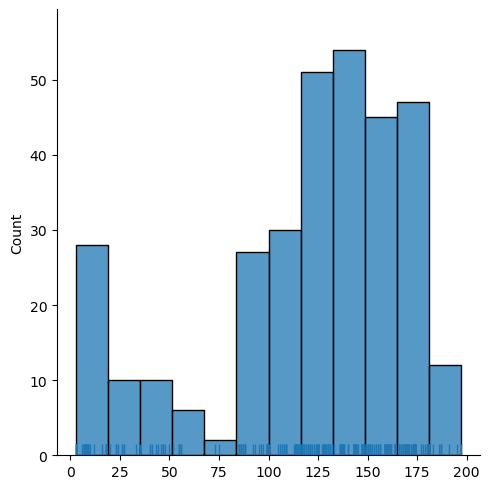

In [50]:
# In order to set the length of the document series (maxlen), we visualise the distribution of the number of words per documents.
sizes = []
out = display(progress(0, len(X_training)), display_id=True)
for ii, txt in enumerate(X_training):
    sizes.append(len(word_tokenize(txt)))
    out.update(progress(ii, len(X_training)))

sns.displot(sizes, kde=False, rug=True)

In [51]:
num_words = 2500 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 150 # Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
word_dimension = 50 # dimension of our word vectors.

In [52]:
word2vec

{'UNK': array([ 0.43547472,  0.30128115, -0.1182373 ,  0.3635854 , -0.22291368,
        -0.18414971,  0.4309964 , -0.3324405 , -0.4555976 , -0.37906814,
        -0.40547556,  0.3108526 , -0.34132212,  0.28938746, -0.23382938,
         0.28466654, -0.31478685, -0.43842643, -0.25799453,  0.3627047 ,
        -0.16167311, -0.29441476,  0.24655053,  0.34056148,  0.3601933 ,
        -0.12335898,  0.3620605 ,  0.23537529, -0.3842004 , -0.42315853,
        -0.24136828, -0.28304172, -0.4113779 , -0.39434007,  0.40483207,
         0.27768227,  0.41000086,  0.37325555, -0.4119789 ,  0.40337592,
         0.24815853,  0.4423334 , -0.2769835 , -0.24424171,  0.30239412,
         0.41168892, -0.40888083,  0.4170406 , -0.4622242 ,  0.23552886],
       dtype=float32),
 'the': array([ 0.33627445,  0.1961598 , -0.08550315,  0.37016284, -0.426051  ,
        -0.16388609,  0.3121804 , -0.3742118 , -0.24181484, -0.3071872 ,
        -0.24495354,  0.3093338 , -0.2743151 ,  0.37109184, -0.2758381 ,
         0.37

In [53]:
# The Tokenizer provided by the Keras library allows to perform such transformation.
keras_tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
keras_tokenizer.fit_on_texts(X_training)
# word_index is the dictionary that contains the index of each words in our 2500 long vocabulary.
word_index = keras_tokenizer.word_index
sequences_train = keras_tokenizer.texts_to_sequences(X_training)
sequences_test = keras_tokenizer.texts_to_sequences(X_testing)

In [54]:
print('Text : '+ X_training[0])
print('Index sequences : ' +str(sequences_train[0]))

Text : Vanguard Russell 1000 Index Fund <head_breaker>

Vanguard Russell 1000 Index Fund

Investment Objective

The Fund seeks to track the performance of a benchmark index that measures the investment return of large-capitalization stocks in the United States.

Fees and Expenses

The following table describes the fees and expenses you may pay if you buy and hold Institutional Shares of the Fund.

Shareholder Fees (Fees paid directly from your investment)

Sales Charge (Load) Imposed on Purchases	None Purchase Fee	None Sales Charge (Load) Imposed on Reinvested Dividends	None Redemption Fee	None

Annual Fund Operating Expenses (Expenses that you pay each year as a percentage of the value of your investment)

Management Fees	0.07% 12b-1 Distribution Fee	None Other Expenses	0.01% Total Annual Fund Operating Expenses	0.08%

Example
Index sequences : [640, 305, 585, 73, 5, 51, 52, 640, 305, 585, 73, 5, 8, 24, 2, 5, 46, 7, 691, 2, 109, 4, 10, 775, 73, 14, 692, 2, 8, 92, 4, 156, 157, 29, 6, 2

In [55]:
feature_train = pad_sequences(sequences_train, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test = pad_sequences(sequences_test, maxlen=maxlen, dtype=float, padding='post', truncating='post')

In [56]:
print ('length of the first sequence : '+str(len(sequences_train[0])) )
print ('length of the paded first sequence : '+str(len(feature_train[0])) )

length of the first sequence : 131
length of the paded first sequence : 150


In [57]:
embedding_matrix = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [58]:
embedding_matrix[2]

array([ 0.33627445,  0.19615979, -0.08550315,  0.37016284, -0.42605099,
       -0.16388609,  0.3121804 , -0.37421179, -0.24181484, -0.3071872 ,
       -0.24495354,  0.3093338 , -0.27431509,  0.37109184, -0.27583811,
        0.37733674, -0.39210355, -0.40622765, -0.22234198,  0.39518002,
        0.06802712, -0.08944029,  0.23085958,  0.25432014,  0.2655057 ,
       -0.2305768 ,  0.28293228,  0.15891677, -0.31272453, -0.41223168,
       -0.20063664, -0.19191048, -0.40589708, -0.3411985 ,  0.14237401,
        0.29172963,  0.2286714 ,  0.39686558, -0.42597145,  0.28216186,
        0.32092562,  0.16267955, -0.12873739, -0.41810238,  0.17650422,
        0.28884003, -0.17910004,  0.39993399, -0.34448451,  0.31502053])

In [59]:
embedding_matrix.shape

(1767, 50)

In [60]:
len(word_index) + 1

1767

In [61]:
word_dimension

50

In [62]:
label_map = {
    'Equity Long Only (Low Risk)': 0,
    'Balanced Fund (Low Risk)': 1,
    'Fixed Income Long Only (Low Risk)': 2
}

Y_training_encoded = Y_training.map(label_map).values
Y_testing_encoded = Y_testing.map(label_map).values


## Gradient Boosting

In [63]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [64]:
grad_boost = HistGradientBoostingClassifier()

In [65]:
grad_boost_grid = {"max_iter": [100, 200, 300],
                   "max_depth": [1, 3, 5, 7],
                   "learning_rate": [0.01, 0.1, 0.2],
                   "l2_regularization": [0.01, 0.1, 1]}

grid_search_grad_boost = GridSearchCV(grad_boost, grad_boost_grid, cv=3, scoring='accuracy', verbose=1, refit=True)

In [66]:
grad_model = grid_search_grad_boost.fit(feature_train, Y_training_encoded)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [67]:
y_pred_grad = grad_model.predict(feature_test)

In [68]:
grad_model.score(feature_test, Y_testing_encoded)

0.7410071942446043

In [69]:
grad_model.best_params_

{'l2_regularization': 0.1,
 'learning_rate': 0.1,
 'max_depth': 5,
 'max_iter': 200}

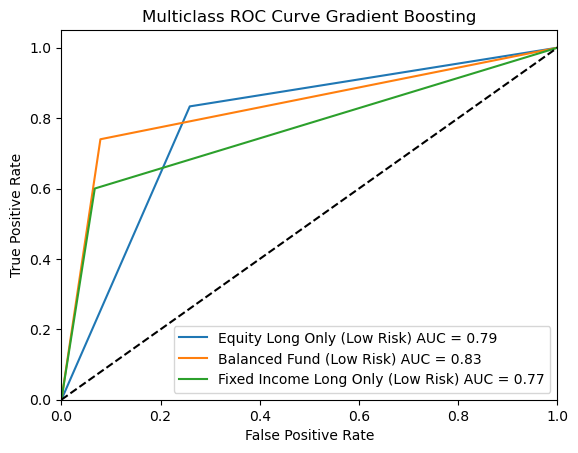

In [70]:
from sklearn.metrics import roc_curve, auc

classes = [0, 1, 2]

plt.figure()
for i in range(len(classes)):
    
    y_class_true = tf.keras.utils.to_categorical(Y_testing_encoded)[:,i]
    y_class_pred = tf.keras.utils.to_categorical(y_pred_grad)[:,i]

    fpr, tpr, _ = roc_curve(y_class_true, y_class_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{list(label_map.keys())[i]} AUC = {roc_auc:.2f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve Gradient Boosting')
plt.legend(loc='lower right')
plt.show()

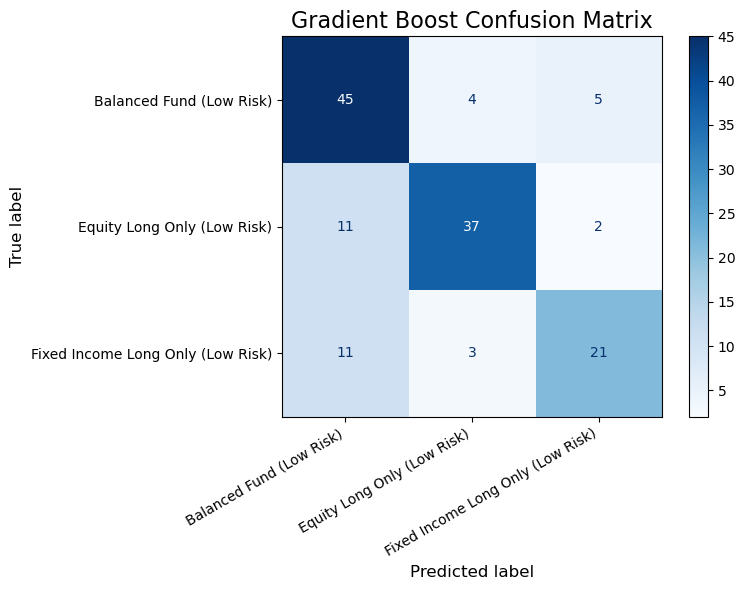

In [71]:
cm = confusion_matrix(Y_testing_encoded, y_pred_grad)

# Class names (based on your label map)
class_names = ['Balanced Fund (Low Risk)', 'Equity Long Only (Low Risk)', 'Fixed Income Long Only (Low Risk)']

# Plot with larger size and clearer labels
plt.figure(figsize=(8, 6))  # Bigger size
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())

plt.title("Gradient Boost Confusion Matrix", fontsize=16)
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.xticks(rotation=30, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [91]:
strategy_labels = [
    'Balanced Fund (Low Risk)',
    'Equity Long Only (Low Risk)',
    'Fixed Income Long Only (Low Risk)'
]

In [94]:
print(classification_report(Y_testing_encoded, y_pred_grad, target_names=strategy_labels, output_dict=False))

                                   precision    recall  f1-score   support

         Balanced Fund (Low Risk)       0.67      0.83      0.74        54
      Equity Long Only (Low Risk)       0.84      0.74      0.79        50
Fixed Income Long Only (Low Risk)       0.75      0.60      0.67        35

                         accuracy                           0.74       139
                        macro avg       0.75      0.72      0.73       139
                     weighted avg       0.75      0.74      0.74       139



## SVM

In [72]:
from sklearn.svm import NuSVC

svmgrid = {
    'nu': np.linspace(0.1, 1, 5),
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
}

grid_search_NuSVM = GridSearchCV( NuSVC(), svmgrid, cv=3, refit=True, n_jobs=-1)

NuSVM_model = grid_search_NuSVM.fit(feature_train, Y_training_encoded)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py", line 258, in fit
    fit(X, y, sample_wei

In [73]:
print(NuSVM_model.score(feature_test, Y_testing_encoded))
y_pred_nu = NuSVM_model.predict(feature_test)

0.6762589928057554


In [74]:
NuSVM_model.best_params_

{'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.1}

In [96]:
print(classification_report(Y_testing_encoded, y_pred_nu, target_names=strategy_labels, output_dict=False))

                                   precision    recall  f1-score   support

         Balanced Fund (Low Risk)       0.60      0.74      0.66        54
      Equity Long Only (Low Risk)       0.83      0.70      0.76        50
Fixed Income Long Only (Low Risk)       0.63      0.54      0.58        35

                         accuracy                           0.68       139
                        macro avg       0.69      0.66      0.67       139
                     weighted avg       0.69      0.68      0.68       139



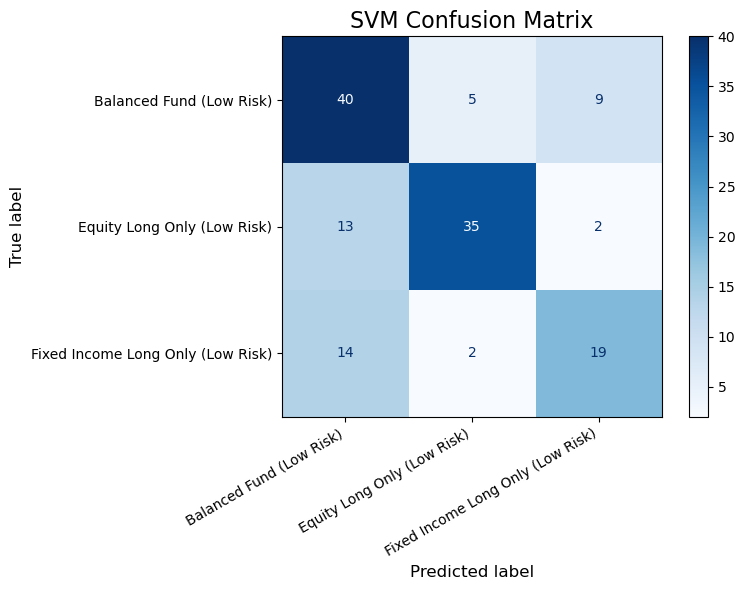

In [75]:
cm = confusion_matrix(Y_testing_encoded, y_pred_nu)

# Class names (based on your label map)
class_names = ['Balanced Fund (Low Risk)', 'Equity Long Only (Low Risk)', 'Fixed Income Long Only (Low Risk)']

# Plot with larger size and clearer labels
plt.figure(figsize=(8, 6))  # Bigger size
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())

plt.title("SVM Confusion Matrix", fontsize=16)
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.xticks(rotation=30, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

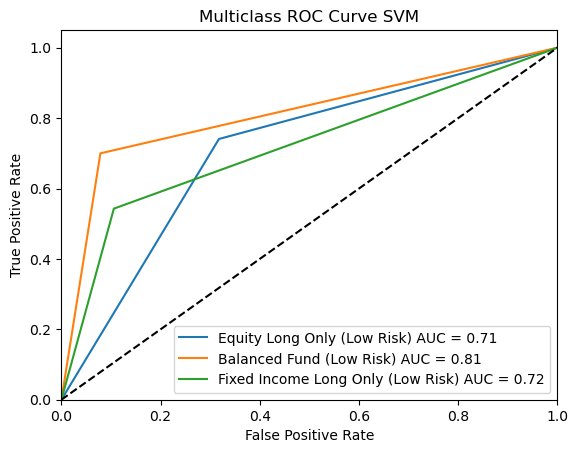

In [76]:
plt.figure()
for i in range(len(classes)):
    
    y_class_true = tf.keras.utils.to_categorical(Y_testing_encoded)[:,i]
    y_class_pred = tf.keras.utils.to_categorical(y_pred_nu)[:,i]

    fpr, tpr, _ = roc_curve(y_class_true, y_class_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{list(label_map.keys())[i]} AUC = {roc_auc:.2f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve SVM')
plt.legend(loc='lower right')
plt.show()

In [97]:
NuSVM_model.score(feature_test, Y_testing_encoded)

0.6762589928057554

# Random Forest

In [77]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [1, 3, 5, 7],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_rf = GridSearchCV(rf, rf_grid, cv=3, scoring='accuracy', refit=True)
rf_model = grid_search_rf.fit(feature_train, Y_training_encoded)

In [78]:
rf_model.score(feature_test, Y_testing_encoded)

0.7266187050359713

In [79]:
rf_model.best_params_

{'max_depth': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 15,
 'n_estimators': 200}

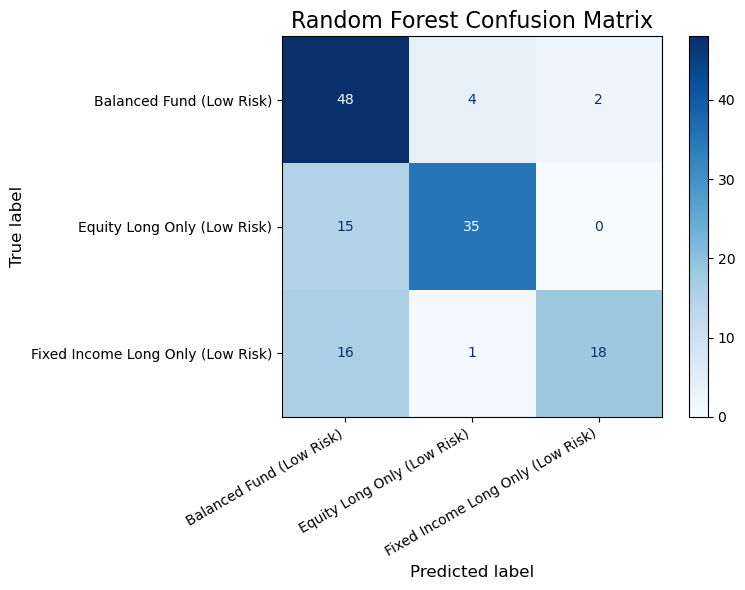

In [80]:
y_pred_rf = rf_model.predict(feature_test)
cm = confusion_matrix(Y_testing_encoded, y_pred_rf)

# Class names (based on your label map)
class_names = ['Balanced Fund (Low Risk)', 'Equity Long Only (Low Risk)', 'Fixed Income Long Only (Low Risk)']

# Plot with larger size and clearer labels
plt.figure(figsize=(8, 6))  # Bigger size
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())

plt.title("Random Forest Confusion Matrix", fontsize=16)
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.xticks(rotation=30, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [95]:
print(classification_report(Y_testing_encoded, y_pred_rf, target_names=strategy_labels, output_dict=False))

                                   precision    recall  f1-score   support

         Balanced Fund (Low Risk)       0.61      0.89      0.72        54
      Equity Long Only (Low Risk)       0.88      0.70      0.78        50
Fixed Income Long Only (Low Risk)       0.90      0.51      0.65        35

                         accuracy                           0.73       139
                        macro avg       0.79      0.70      0.72       139
                     weighted avg       0.78      0.73      0.73       139



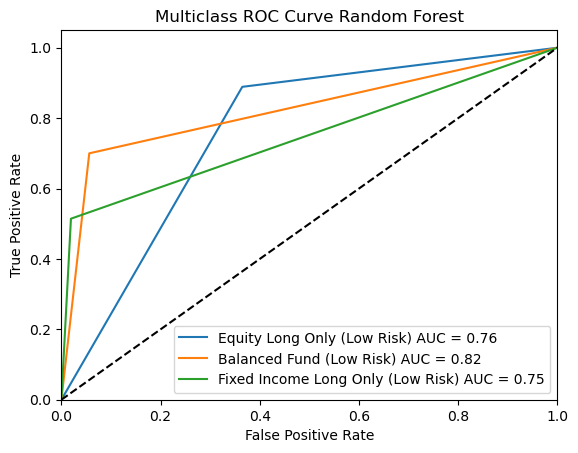

In [81]:
plt.figure()
for i in range(len(classes)):
    
    y_class_true = tf.keras.utils.to_categorical(Y_testing_encoded)[:,i]
    y_class_pred = tf.keras.utils.to_categorical(y_pred_rf)[:,i]

    fpr, tpr, _ = roc_curve(y_class_true, y_class_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{list(label_map.keys())[i]} AUC = {roc_auc:.2f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve Random Forest')
plt.legend(loc='lower right')
plt.show()